# Engagement Inference for Trending Youtube Videos - Feature Engineering Visualisation

## Contents:
* [Framing the problem](#0)
<!-- * [Performance measure ](#1) -->
* [Loading and Preprocessing](#2)
* [Preliminary Analysis](#4)
* [Feature Engineering](#5)
    * [Thumbnail Image Contrast Feature Extraction](#6)
    * [Tags Feature Extraction](#7.5)
    * [Title Feature Extraction](#7)
    * [Description Feature Extraction](#8)
* [Analysis of key features](#8.5)
* [Baseline](#9)

### Framing the problem <a id="0"></a>

What is our business objective? 
- Infering the utility of title, tags, thumbnail, and more attributes for video engagement.


#### Imports

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
import requests
import cv2
import nltk
import missingno
import emoji
import regex
import re
import time

from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, classification_report
from sklearn.svm import SVR
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import scatter_matrix

from PIL import Image
from io import BytesIO
from collections import Counter
from gensim import corpora
from numpy import linalg as LA
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize

%matplotlib inline
nltk.download('stopwords')
nltk.download('vader_lexicon')

import prepare_features

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmiskell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/danielmiskell/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Loading and Preprocessing <a id="2"></a>

In [2]:
df_gb = pd.read_csv('GBvideos.csv')
df_us = pd.read_csv('USvideos.csv')

# concatenate GB and US dataframes
df = pd.concat([df_gb, df_us])
df = df.drop_duplicates(subset = ['video_id', 'trending_date'])

# transform dates to datetime forward
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

### Aggregating the Data

In [3]:
# get a snapshot of video lifetime over its trending period

df_aff = df.groupby(['video_id']).agg(
    # views TRending Starts
    views_trs = pd.NamedAgg(column = 'views', aggfunc = 'first'),
    
    # views TRending Ends
    views_tre = pd.NamedAgg(column = 'views', aggfunc = 'last'),
    
    # same for likes, dislikes and comments
    likes_trs = pd.NamedAgg(column = 'likes', aggfunc = 'first'),
    likes_tre = pd.NamedAgg(column = 'likes', aggfunc = 'last'),
    dislk_trs = pd.NamedAgg(column = 'dislikes', aggfunc = 'first'),
    dislk_tre = pd.NamedAgg(column = 'dislikes', aggfunc = 'last'),
    comms_trs = pd.NamedAgg(column = 'comment_count', aggfunc = 'first'),
    comms_tre = pd.NamedAgg(column = 'comment_count', aggfunc = 'last'),
    
    # date it gets on trending
    trending_start = pd.NamedAgg(column = 'trending_date', aggfunc = min),
    trending_end = pd.NamedAgg(column = 'trending_date', aggfunc = max),
    # integer value of number of days on trending
    days_trending = pd.NamedAgg(column = 'trending_date', aggfunc = lambda d: (max(d) - min(d)).days)
)

### Basic Feature Engineering

In [4]:
# engineered features
df_aff['days_trending'] = (df_aff["trending_end"]-df_aff["trending_start"]).dt.days
df_aff['views_gain'] = df_aff["views_tre"]-df_aff["views_trs"]
df_aff['likes_gain'] = df_aff["likes_tre"]-df_aff["likes_trs"]
df_aff['dislk_gain'] = df_aff["dislk_tre"]-df_aff["dislk_trs"]
df_aff['comms_gain'] = df_aff['comms_tre'] - df_aff['comms_trs']
df_aff['likes_view'] = (df_aff["likes_gain"]/df_aff["views_gain"])/ df_aff['days_trending']

### Target Feature Definiton

In [5]:
# engagement feature

df_aff['engagement'] = (10*df_aff['comms_gain'] + df_aff['likes_gain'])/df_aff['views_gain']
df_aff = df_aff[(df_aff['engagement'] > -1) & (df_aff['engagement'] < 1)]

# sns.distplot(df_aff[(df_aff['engagement'] > -0.15) & (df_aff['engagement'] < 0.15)]['engagement']).set_title("Distribition of Engagement")
# plt.show()

df_aff = df_aff.reset_index()

# pull additional columns into the new data set
df_all = df_aff.merge(df[['video_id','title', 'channel_title', 'category_id','publish_time', 'tags', 'description', 'thumbnail_link', 'views','likes', 'dislikes', 'comment_count']], how = 'right', on = 'video_id')
df_all = df_all.drop_duplicates(subset = 'video_id')

# drop columns with missing values originated from clipping engagement values
df_all = df_all.dropna()

# Feature Engineering <a id="5"></a>

In [6]:
# more engineered features
df_all['publish_to_trending'] = df_all['trending_start'] - df_all['publish_time']
df_all['publish_to_trending'] = df_all['publish_to_trending'].apply(lambda x: x.days)

## Thumbnail Image Contrast Feature Extraction <a id="6"></a>

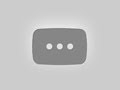

In [7]:
prepare_features.show_image(prepare_features.empty_thumbnail_url)

In [8]:
start_time = time.time()
df_all['thumbnail_contrast'] = df_all.apply(lambda row: prepare_features.thumbnail_contrast(row['thumbnail_link']), axis=1)
print("--- %s minutes ---" % (str(round((time.time() - start_time)/60, 1))))

--- 21.4 minutes ---


In [9]:
print("{0:0.1f} percent empty thumbnails or wrong shape.".format(100*(df_all[np.isnan(df_all['thumbnail_contrast'])].shape[0]/ df_all.shape[0])))
print("{} empty thumbnails or wrong shape out of {}.".format(df_all[np.isnan(df_all['thumbnail_contrast'])].shape[0], df_all.shape[0]))

7.3 percent empty thumbnails or wrong shape.
556 empty thumbnails or wrong shape out of 7636.


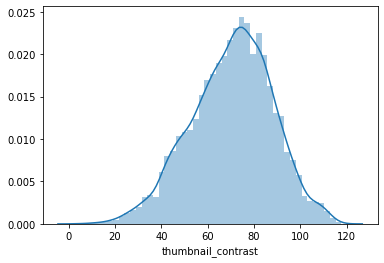

In [10]:
sns.distplot(df_all[df_all['thumbnail_contrast'].notnull()]['thumbnail_contrast'])

In [11]:
# Remove empty values
df_all = df_all[df_all['thumbnail_contrast'].notnull()]

### Save & load checkpoint

In [12]:
# Save dataframe to pickle file as processing takes a long time
df_all.to_pickle("df_all.pkl")

In [146]:
df_all = pd.read_pickle("df_all.pkl")

## Tags Feature Extraction <a id="7.5"></a>

In [147]:
# example
tag_example = 'edsheeran|"ed sheeran"|"acoustic"|"live"|"cover"|"official"|"remix"|"official video"|"lyrics"|"session"'
prepare_features.process_tags(tag_example)

['edsheeran',
 'ed',
 'sheeran',
 'acoustic',
 'live',
 'cover',
 'official',
 'remix',
 'official',
 'video',
 'lyrics',
 'session']

In [148]:
# process tags string into word list of tags
df_all['tags'] = df_all['tags'].apply(prepare_features.process_tags)

In [149]:
prepare_features.letters_per_word(prepare_features.process_tags(tag_example))

6.166666666666667

In [150]:
# average number of letters per word in a videos tags
df_all['tags_letters_per_word'] = df_all['tags'].apply(prepare_features.letters_per_word)

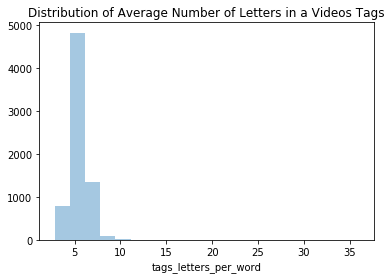

In [151]:
sns.distplot(df_all['tags_letters_per_word'], kde = False, bins = 20).set_title("Distribution of Average Number of Letters in a Videos Tags")
plt.show()

In [152]:
# number of words in a videos tags
df_all['tags_num_words'] = df_all['tags'].apply(len)

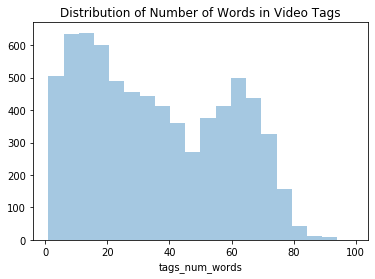

In [153]:
sns.distplot(df_all['tags_num_words'], kde = False, bins = 20).set_title('Distribution of Number of Words in Video Tags')
plt.show()

In [154]:
len(prepare_features.process_tags(tag_example))

12

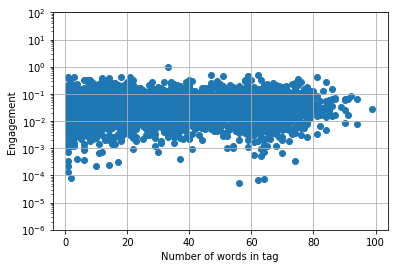

In [155]:
#g = sns.jointplot(df_all['num_words'], df_all['views_gain'] )
#g.ax_joint.set_xscale('log'); #g.ax_joint.set_yscale('log')
plt.scatter(df_all['tags_num_words'], df_all['engagement'])
#plt.xscale('log'); 
plt.yscale('log'); 
plt.ylim([10**-6, 10**2]); 
plt.grid()
plt.xlabel("Number of words in tag"); plt.ylabel("Engagement")
plt.show()

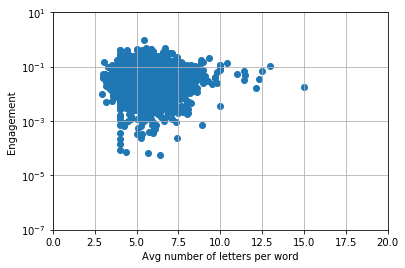

In [156]:
#g = sns.jointplot(df_all['letters_per_word'], df_all['views_gain'] )
#g.ax_joint.set_xscale('log'); #g.ax_joint.set_yscale('log')
plt.scatter(df_all['tags_letters_per_word'], df_all['engagement'])
#plt.xscale('log'); 
plt.yscale('log'); 
plt.ylim([10**-7, 10**1]); plt.xlim([0, 20]); 
plt.grid()
plt.xlabel("Avg number of letters per word"); plt.ylabel("Engagement")
plt.show()

In [157]:
df_all.groupby(['category_id']).mean()['engagement']              

category_id
1     0.042644
2     0.025541
10    0.037184
15    0.037510
17    0.020046
19    0.035211
20    0.041664
22    0.045295
23    0.049182
24    0.037707
25    0.040457
26    0.048695
27    0.046111
28    0.036681
29    0.057079
43    0.036737
Name: engagement, dtype: float64

## Title Feature Extraction <a id="7"></a>

### 'title_caps_count' (int)

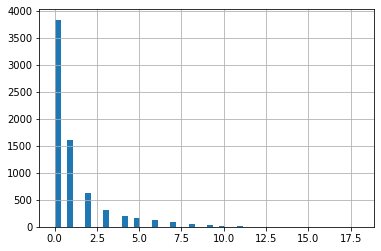

In [158]:
df_all['title_caps_count'] = df_all['title'].apply(prepare_features.remove_punctuation).apply(prepare_features.count_caps)
df_all['title_caps_count'].hist(bins=50)

### 'title_words_count' (int)

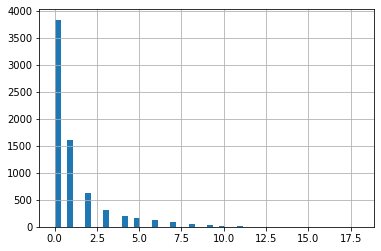

In [159]:
df_all['title_words_count'] = df_all['title'].apply(prepare_features.remove_punctuation).apply(prepare_features.count_caps)
df_all['title_words_count'].hist(bins=50)

### 'title_sentiment' (float)

VADER, a lexicon and rule-based sentiment analyser (Hutto and Gilbert 2014) was used to score  sentiment analysis from 'A Data-Driven Study of View Duration on YouTube' by Park, Naaman and Berger (2016) so it is relevant to consider it's application to the sentiment intensity and polarity of the video title.

In [160]:
### Warning - VERY slow to apply sentiment score to each row of the DataFrame (~10 minutes for 40K rows)
start_time = time.time()
df_all['title_sentiment'] = df_all['title'].apply(prepare_features.get_sentiment)
print("--- %s minutes ---" % (str(round((time.time() - start_time)/60,1))))

--- 1.0 minutes ---


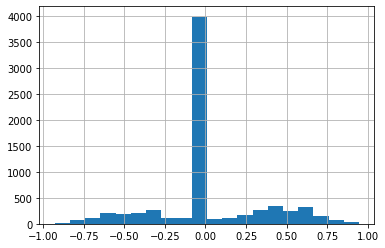

In [161]:
df_all['title_sentiment'].hist(bins=20)

## Save & load checkpoint

In [162]:
# save as pickle file
df_all.to_pickle("df_title_sentiment.pkl")

In [163]:
# load pickle file
df_all = pd.read_pickle("df_title_sentiment.pkl")

### 'title_exclaimation_mark_count' (int)

In [164]:
df_all['title_exclaimation_mark_count'] = df_all['title'].apply(prepare_features.count_exclaim)
df_all['title_exclaimation_mark_count'].value_counts()

0    6304
1     629
2      97
3      40
4       8
6       1
5       1
Name: title_exclaimation_mark_count, dtype: int64

### 'title_question_count' (int)

In [165]:
df_all['title_question_count'] = df_all['title'].apply(prepare_features.count_question)
df_all['title_question_count'].value_counts()

0    6697
1     366
2      14
3       3
Name: title_question_count, dtype: int64

### 'title_emoji_count' (int)

In [166]:
df_all['title_emoji_count'] = df_all['title'].apply(prepare_features.count_emoji)
df_all['title_emoji_count'].value_counts()

0    6981
1      64
2      27
3       7
4       1
Name: title_emoji_count, dtype: int64

## Description Feature Extraction <a id="8"></a>

In [167]:
# Empty rows are assigned as empty string to ensure consistent string input when executing functions  -->
df_all[df_all['description'].isnull()] = ''

### 'desc_lines' (int)
- Number of lines in description

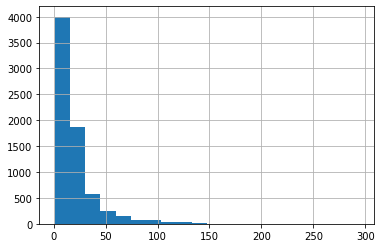

In [168]:
df_all['desc_lines'] = df_all['description'].apply(prepare_features.desc_lines)
df_all['desc_lines'].hist(bins=20)

### 'desc_action_invite'

* feature whether description contains text directly trying to make the audience engage

In [169]:
df_all['desc_action_invite'] = df_all['description'].apply(lambda x: len(re.findall(r'\blike|comment|subscribe\b',x.lower())))

### 'desc_url_count' (int)
- number of URLs in description

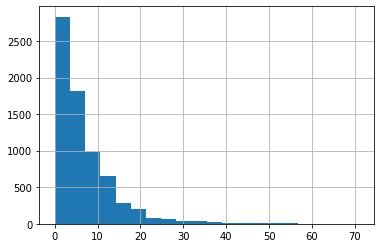

In [170]:
df_all['desc_url_count'] = df_all['description'].head(10000).apply(prepare_features.desc_urls_count)
df_all['desc_url_count'].hist(bins=20)

### 'desc_len' (int)

In [172]:
df_all['desc_len'] = df_all['description'].apply(lambda x: prepare_features.desc_len(x))

### 'desc_caps_count' (int)

In [173]:
df_all['desc_caps_count'] = df_all['description'].apply(lambda x: prepare_features.desc_upper(x))

In [174]:
# save as pickle file
df_all.to_pickle("df_inference.pkl")

In [175]:
# load pickle file
df_all = pd.read_pickle("df_inference.pkl")

## Analysis of key features <a id="8.5"></a>

In [177]:
X = df_all.drop(['video_id', 'views_tre', 'likes_tre', 'dislk_tre', 'comms_tre', 'trending_start', 'trending_end', 'views_gain', 'likes_gain', 'dislk_gain', 'comms_gain', 'likes_view', 'channel_title', 'publish_time', 'tags', 'thumbnail_link','views','likes', 'dislikes', 'comment_count'], axis = 1)
y = X['engagement'].astype(float)

X[['days_trending', 'publish_to_trending']] = X[['days_trending', 'publish_to_trending']].astype(int)
X[['thumbnail_contrast', 'tags_letters_per_word', 'title_sentiment']] = X[['thumbnail_contrast', 'tags_letters_per_word', 'title_sentiment']].astype(float)
X[['tags_num_words', 'title_caps_count', 'title_words_count', 'title_exclaimation_mark_count', 'title_question_count']] = X[['tags_num_words', 'title_caps_count', 'title_words_count', 'title_exclaimation_mark_count', 'title_question_count']].astype(int)
X[['title_emoji_count']] = X[['title_emoji_count']].astype(int)
X['engagement'] = X['engagement'].astype(float)

In [178]:
corr_matrix = X.corr()
corr_matrix['engagement'].sort_values(ascending=False)

engagement                       1.000000
title_words_count                0.084365
title_caps_count                 0.084365
thumbnail_contrast               0.064244
desc_caps_count                  0.035463
desc_lines                       0.028324
title_question_count             0.027737
desc_url_count                   0.019008
days_trending                    0.012785
title_exclaimation_mark_count    0.011227
title_emoji_count                0.010375
tags_letters_per_word            0.006634
desc_action_invite              -0.015764
tags_num_words                  -0.017277
desc_len                        -0.021858
title_sentiment                 -0.028645
publish_to_trending             -0.031946
Name: engagement, dtype: float64

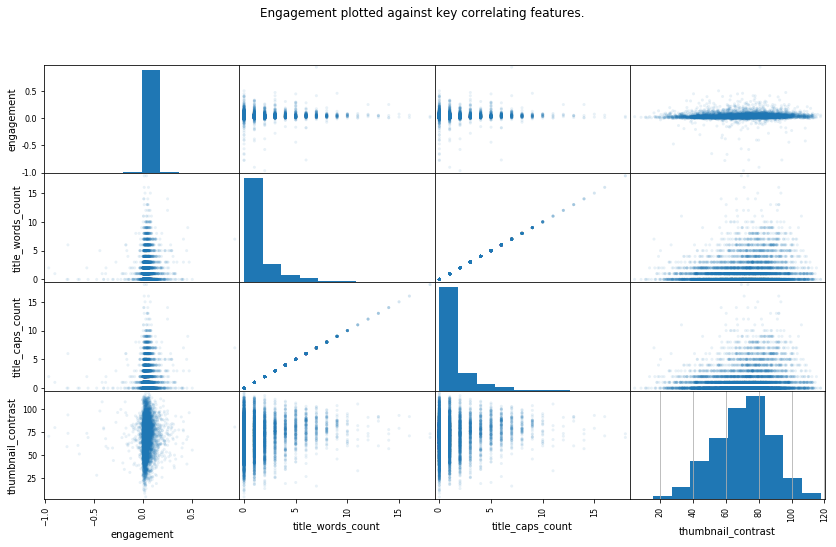

In [179]:
attributes = ["engagement", "title_words_count", "title_caps_count", "thumbnail_contrast"]
scatter_matrix(X[attributes], figsize=(14, 8), alpha=0.1)
plt.suptitle("Engagement plotted against key correlating features.")
plt.grid()
plt.show()

## Inference Baseline <a id="9"></a>

In [180]:
X = X.drop(['engagement', 'views_trs', 'likes_trs', 'dislk_trs', 'comms_trs', 'title', 'description'], axis = 1)

In [181]:
X = pd.get_dummies(X, columns = ['category_id'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)

In [182]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [183]:
y_pred = regressor.predict(X_test)

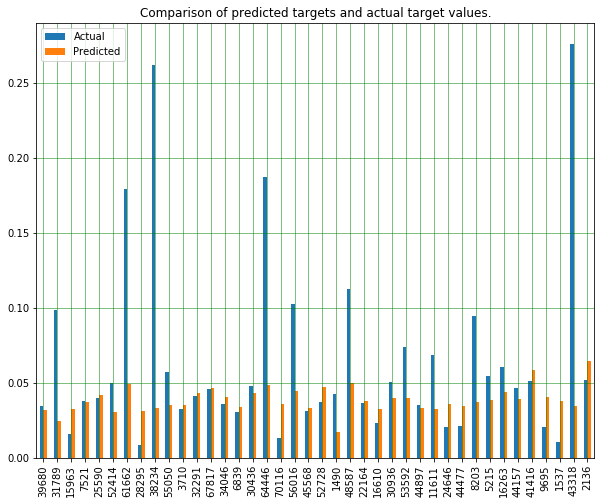

In [184]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df1.head(40)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Comparison of predicted targets and actual target values.")
plt.show()

In [185]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.026598374898886123
Mean Squared Error: 0.0029352659617258342
Root Mean Squared Error: 0.05417809485138652


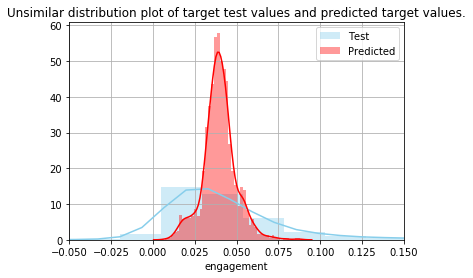

In [186]:
sns.distplot(y_test , color="skyblue", label="Test")
sns.distplot( y_pred , color="red", label="Predicted")
# sns.plt.legend()
plt.xlim([-0.05, 0.15])
plt.legend()
plt.grid()
plt.title("Unsimilar distribution plot of target test values and predicted target values.")
plt.show()